In [1]:
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy

import os
import copy

import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision for GPU performance optimization
set_global_policy('mixed_float16')

# Ensure GPU is detected
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Device:", tf.config.list_physical_devices('GPU'))

# Configure TensorFlow to use GPU memory efficiently
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPU Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth set to True


In [6]:
# Configure TensorFlow to use GPU memory efficiently
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

# Visualization libraries
import seaborn as sns

# Visualization libraries
import seaborn as sns

GPU memory growth set to True


In [7]:
# Image dimensions and batch size
IMG_HEIGHT = 56
IMG_WIDTH = 56
BATCH_SIZE = 128

In [8]:
#Number of possible label values (emotions)
nb_classes = 7

In [9]:
# Path for datasets
train_path = "F21DL_Coursework_grp2/data/train"
validation_path = "F21DL_Coursework_grp2/data/validation"

In [10]:
import os

# Define a function to remove .DS_Store files
def remove_ds_store(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")

# Apply to your dataset directory
remove_ds_store("F21DL_Coursework_grp2/data/train")
remove_ds_store("F21DL_Coursework_grp2/data/validation")

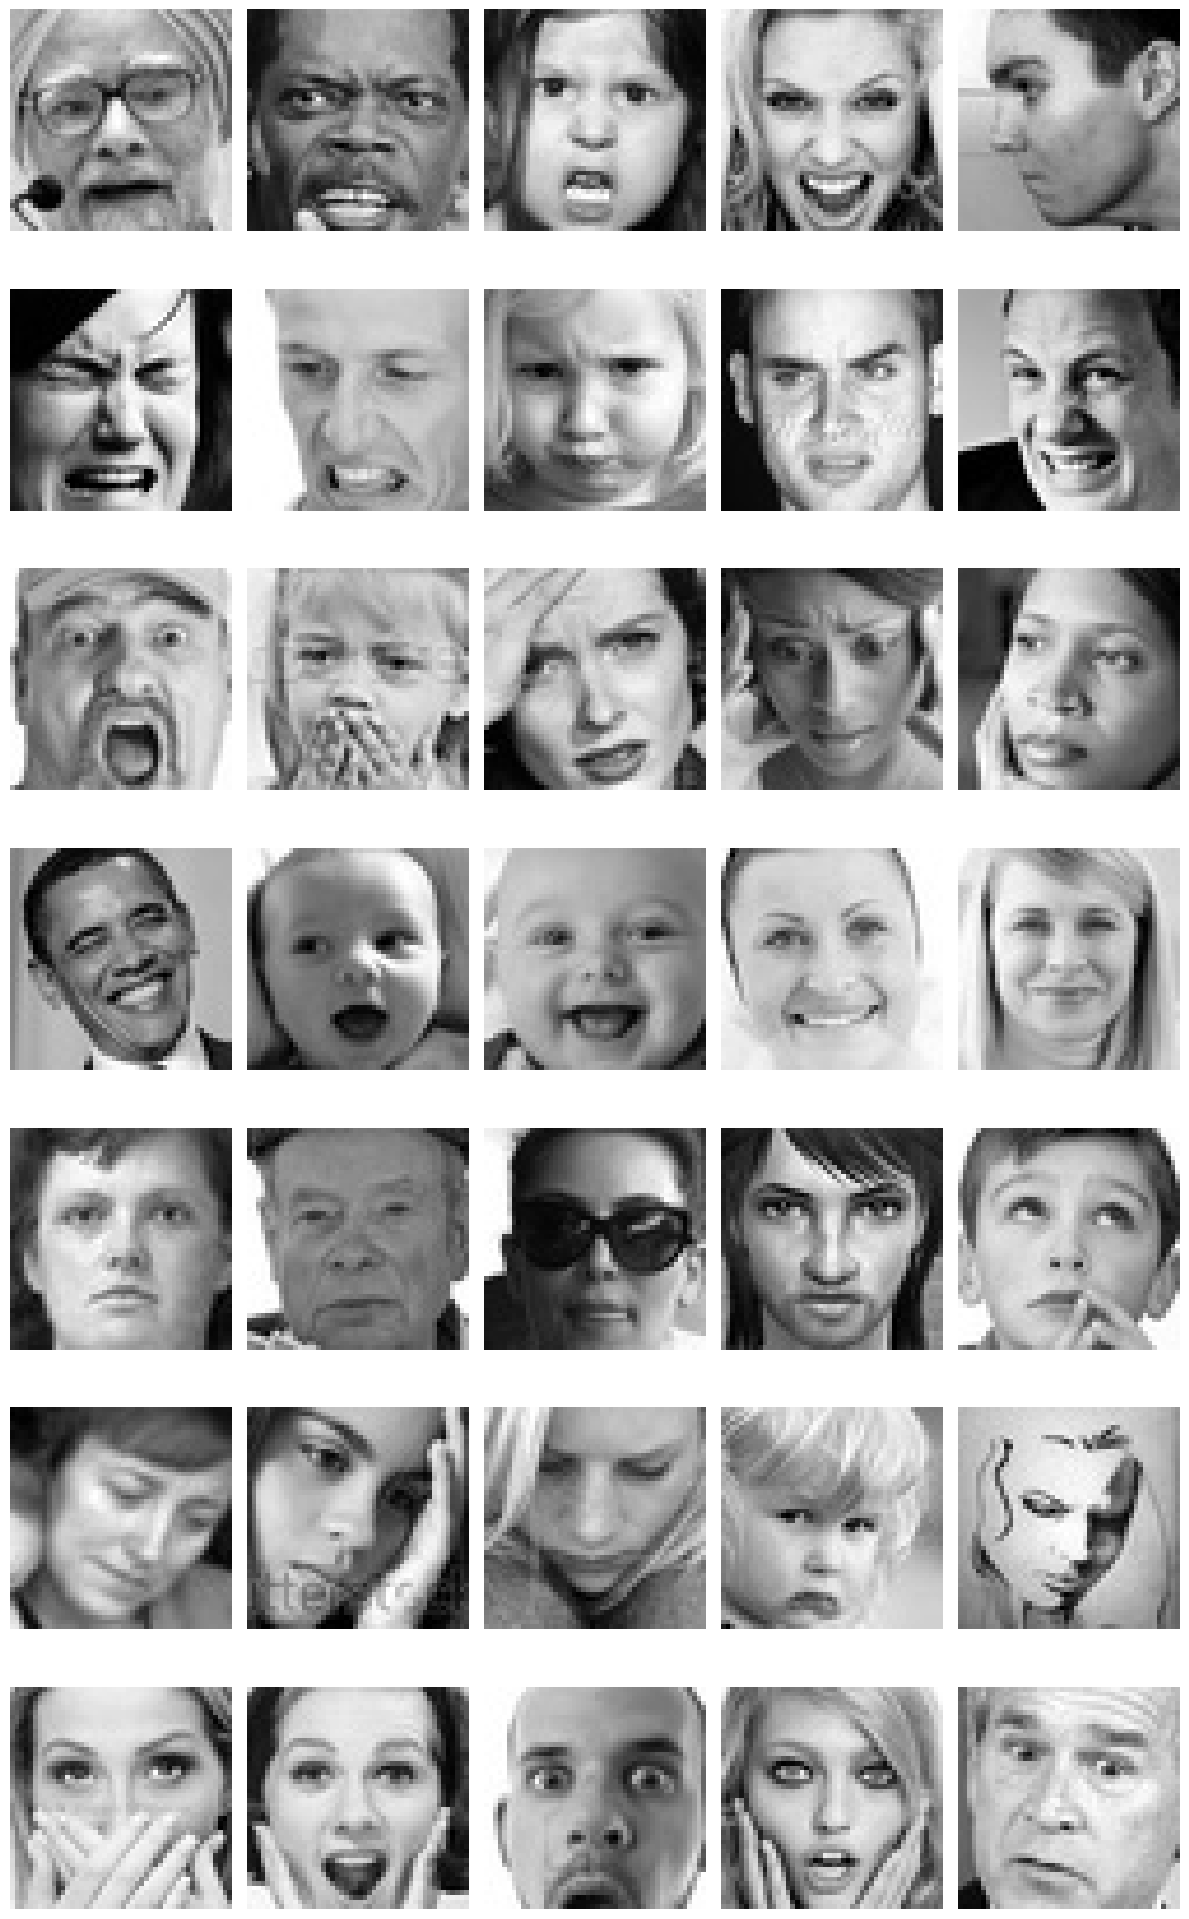

In [11]:
# Step 1: Visualize the dataset
# Display a few images from each expression category
plt.figure(0, figsize=(12, 20))
cpt = 0  # Counter for subplot placement
for expression in os.listdir(train_path):
    for i in range(1, 6):  # Display 5 images per category
        cpt += 1
        plt.subplot(7, 5, cpt)  # 7 rows, 5 columns
        img = cv2.imread(f"{train_path}/{expression}/{os.listdir(train_path + '/' + expression)[i]}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        plt.imshow(img, cmap="gray")
        plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()

In [12]:
# Step 2: Create Data Generators for Training and Validation
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True
)

In [13]:
# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [14]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 28821 images belonging to 7 classes.


In [15]:
# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 7066 images belonging to 7 classes.


In [16]:
# Step 3: Build the CNN Model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolutional Layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolutional Layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolutional Layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully Connected Layer 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(nb_classes, activation='softmax'))

# Print model summary
print(model.summary())

# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       2

In [26]:
# Step 4: Train the Model
epochs = 50  # Number of epochs

# Save the best model using a checkpoint
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list
)

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.0552 - accuracy: 0.5983
Epoch 1: val_accuracy improved from -inf to 0.62457, saving model to model_weights.keras
225/225 [==============================] - 13s 55ms/step - loss: 1.0552 - accuracy: 0.5983 - val_loss: 1.0021 - val_accuracy: 0.6246
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.0591 - accuracy: 0.5981
Epoch 2: val_accuracy improved from 0.62457 to 0.62770, saving model to model_weights.keras
225/225 [==============================] - 12s 55ms/step - loss: 1.0591 - accuracy: 0.5981 - val_loss: 1.0005 - val_accuracy: 0.6277
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.0449 - accuracy: 0.6035
Epoch 3: val_accuracy improved from 0.62770 to 0.62855, saving model to model_weights.keras
225/225 [==============================] - 12s 55ms/step - loss: 1.0449 - accuracy: 0.6035 - val_loss: 0.9994 - val_accuracy: 0.6286
Epoch 4/50
224/225 [====================

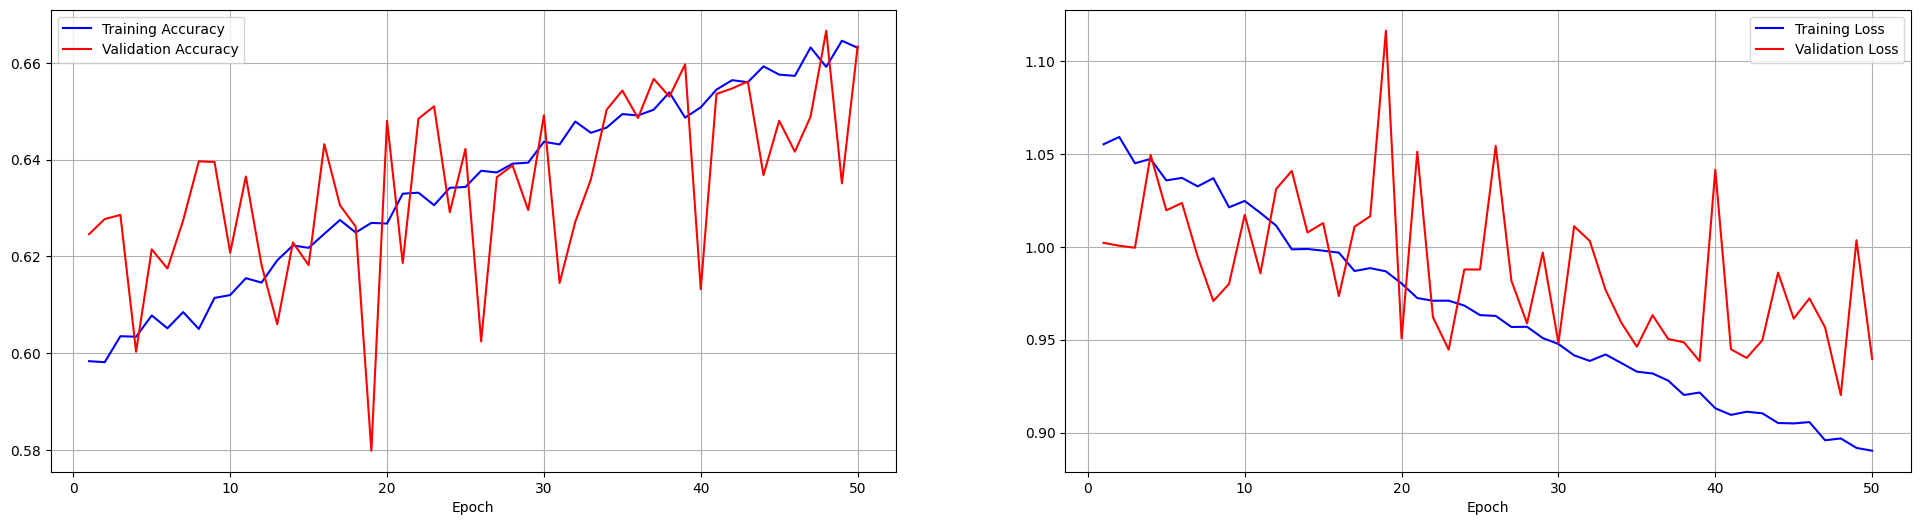

Best Validation Accuracy Score: 0.66662, at Epoch: 48


In [27]:
# Step 5: Visualize Training Results
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

# Function to find the best epoch
def get_best_epoch(history):
    val_acc = history.history['val_accuracy']
    best_epoch = val_acc.index(max(val_acc)) + 1
    best_acc = max(val_acc)
    print(f'Best Validation Accuracy Score: {best_acc:.5f}, at Epoch: {best_epoch}')
    return best_epoch

# Plot training results and best epoch
plot_results(history)
best_epoch = get_best_epoch(history)

Model stopped running, so loaded a saved version of the model to continue running it

In [18]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint to save the best model
checkpoint = ModelCheckpoint(
    "model_weights.keras",  # Path to save the best model
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Create the callbacks list
callbacks_list = [checkpoint]

In [20]:
from keras.models import load_model

# Load the saved model
model = load_model("model_weights.keras")

# Resume training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,  # Adjust based on remaining epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list
)

Epoch 1/5
225/225 [==============================] - ETA: 0s - loss: 1.0811 - accuracy: 0.5912
Epoch 1: val_accuracy improved from -inf to 0.61406, saving model to model_weights.keras
225/225 [==============================] - 13s 55ms/step - loss: 1.0811 - accuracy: 0.5912 - val_loss: 1.0334 - val_accuracy: 0.6141
Epoch 2/5
224/225 [============================>.] - ETA: 0s - loss: 1.0815 - accuracy: 0.5902
Epoch 2: val_accuracy improved from 0.61406 to 0.61747, saving model to model_weights.keras
225/225 [==============================] - 12s 54ms/step - loss: 1.0813 - accuracy: 0.5902 - val_loss: 1.0200 - val_accuracy: 0.6175
Epoch 3/5
224/225 [============================>.] - ETA: 0s - loss: 1.0751 - accuracy: 0.5903
Epoch 3: val_accuracy did not improve from 0.61747
225/225 [==============================] - 12s 54ms/step - loss: 1.0754 - accuracy: 0.5904 - val_loss: 1.0589 - val_accuracy: 0.6016
Epoch 4/5
225/225 [==============================] - ETA: 0s - loss: 1.0648 - accura

In [22]:
# Step 5: Visualize Training Results
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

In [23]:
# Function to find the best epoch
def get_best_epoch(history):
    val_acc = history.history['val_accuracy']
    best_epoch = val_acc.index(max(val_acc)) + 1
    best_acc = max(val_acc)
    print(f'Best Validation Accuracy Score: {best_acc:.5f}, at Epoch: {best_epoch}')
    return best_epoch

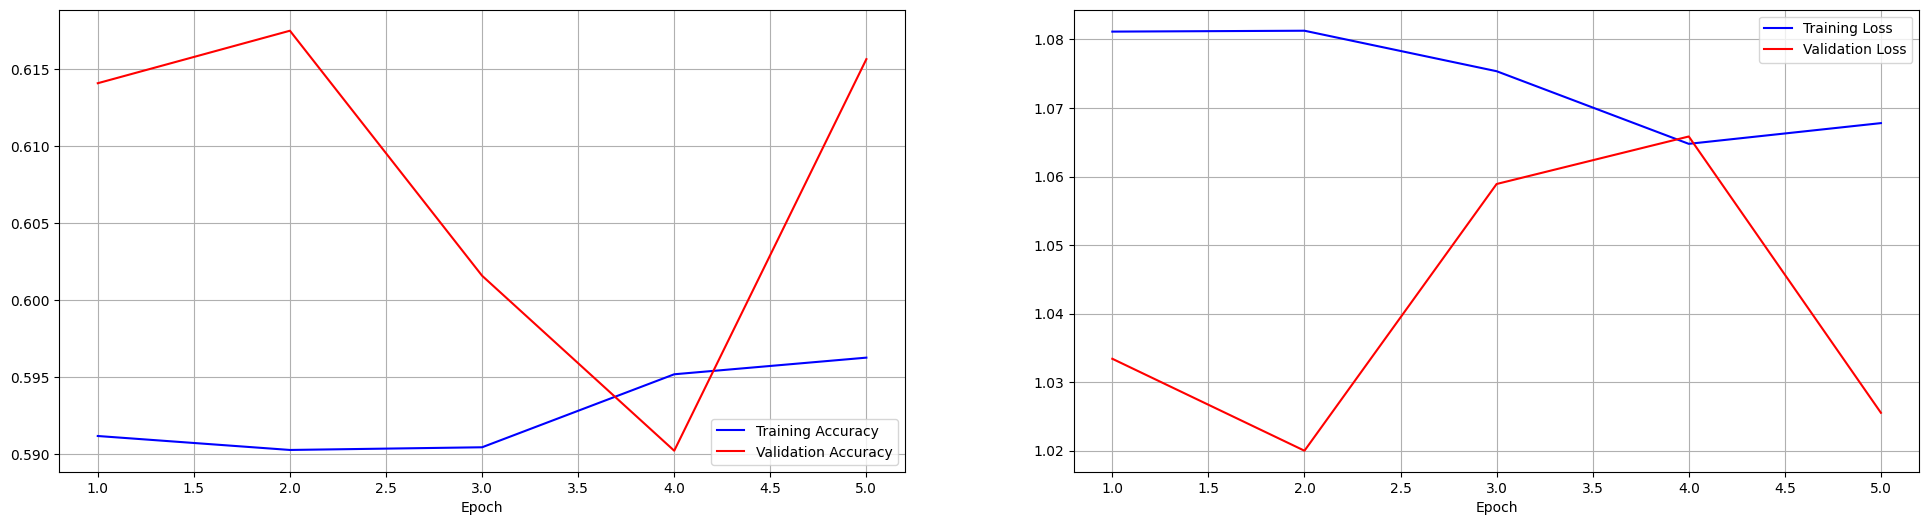

Best Validation Accuracy Score: 0.61747, at Epoch: 2


In [24]:
# Plot training results and best epoch
plot_results(history)
best_epoch = get_best_epoch(history)

# **Real-time Emotion Detection with OpenCV**

In [25]:
# Load the model and its weights
model_json_file = '../input/face-expression-model/model.json'
model_weights_file = '../input/face-expression-model/model_weights.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

FileNotFoundError: [Errno 2] No such file or directory: '../input/face-expression-model/model.json'

In [ ]:
# Load Haarcascade for face detection
face_cascade = cv2.CascadeClassifier('../input/face-expression-model/haarcascade_frontalface_default.xml')

In [ ]:
# Start real-time video capture
cap = cv2.VideoCapture(0)

In [ ]:
while True:
    ret, frame = cap.read()
    img = copy.deepcopy(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        fc = gray[y:y + h, x:x + w]
        roi = cv2.resize(fc, (48, 48))
        pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
        text_idx = np.argmax(pred)
        text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
        text = text_list[text_idx]
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    cv2.imshow("Emotion Detection", img)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Press 'q' to quit
        break

cap.release()
cv2.destroyAllWindows()